In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# X = np.random.uniform(low=-2, high=5, size=(6,8))
# ytrue = np.array([1,0,1,2,0,2])

def get_data(path):
    data = pd.read_csv(path, index_col=0)

    cols = list(data.columns)
    target = cols.pop()

    X = data[cols].copy()
    y = data[target].copy()

    y = LabelEncoder().fit_transform(y)

    return np.array(X), np.array(y)

X, y = get_data(r'C:\Users\12482\Desktop\articles\nn_from_scratch\iris.csv')

In [3]:
class DenseLayer:
    def __init__(self, neurons):
        self.neurons = neurons
        
    def relu(self, inputs):
        return np.maximum(0, inputs)

    def softmax(self, inputs):
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    def relu_derivative(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    
    def forward(self, inputs, weights, bias, activation):
        Z_curr = np.dot(inputs, weights.T) + bias
        
        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)
            
        return A_curr, Z_curr
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr) ## backpropate the gradient to the parameters (W,b)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(W_curr.T, dA_curr.T) ## --> next input for dW (this is dA)
        else:
            dZ = self.relu_derivative(dA_curr.T, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(W_curr.T, dZ.T) ## --> next input for dW (this is dA)
            
        return dA, dW, db

class Network:
    def __init__(self):
        self.network = [] ## layers
        self.architecture = [] ## mapping input neurons --> output neurons
        self.params = [] ## W, b
        self.memory = [] ## Z, A
        self.gradients = [] ## dW, db
        
    def add(self, layer):
        self.network.append(layer)
            
    def _compile(self, data):
        for idx, layer in enumerate(self.network):
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 
                                          'output_dim':layer.neurons, 'activation':'relu'})
            if idx == len(self.network)-2:
                self.architecture.append({'input_dim':layer.neurons, 
                                          'output_dim':self.network[idx+1].neurons, 'activation':'softmax'})
            elif idx != len(self.network)-2 and idx != len(self.network)-1:
                self.architecture.append({'input_dim':layer.neurons, 
                                          'output_dim':self.network[idx+1].neurons, 'activation':'relu'})
            else:
                continue
                
        return self
    
    def _init_weights(self, data):
        self._compile(data)
        
        for i in range(len(self.architecture)):
            self.params.append({
                'W':np.random.uniform(low=-1, high=1, 
                  size=(self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'b':np.zeros((1, self.architecture[i]['output_dim']))})
        
        return self
    
    def _forwardprop(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'], 
                                           bias=self.params[i]['b'], activation=self.architecture[i]['activation'])
            
            self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def _backprop(self, predicted, actual):
        num_samples = len(actual)
        
        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        
        dA_prev = dscores
        
        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            activation = self.architecture[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})
            
    def _update(self, lr=0.01):
        for idx, layer in enumerate(self.network):
            self.params[idx]['W'] -= lr * list(reversed(self.gradients))[idx]['dW'].T     
            self.params[idx]['b'] -= lr * list(reversed(self.gradients))[idx]['db']
    
    def _get_accuracy(self, predicted, actual):
        return np.mean(np.argmax(predicted, axis=1)==actual)
    
    def _calculate_loss(self, predicted, actual):
        samples = len(actual)
        
        probs = predicted / np.sum(predicted, axis=1, keepdims=True)
        correct_logprobs = -np.log(probs[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/150

        return data_loss
    
    def train(self, X_train, y_train, epochs):
        self.loss = []
        self.accuracy = []
        
        self._init_weights(X_train)
        
        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))
            
            self._backprop(predicted=yhat, actual=y_train)
            
            self._update()
            
            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

In [11]:
X1 = np.random.uniform(low=-2, high=5, size=(6,8))
y1 = np.array([1,0,1,2,0,2])

In [5]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(3))

model.train(X_train=X, y_train=y, epochs=200)

EPOCH: 0, ACCURACY: 0.3333333333333333, LOSS: 1.8507288360616592
EPOCH: 20, ACCURACY: 0.64, LOSS: 0.8984484293696664
EPOCH: 40, ACCURACY: 0.5666666666666667, LOSS: 0.8055846210908157
EPOCH: 60, ACCURACY: 0.5933333333333334, LOSS: 0.7544998303196496
EPOCH: 80, ACCURACY: 0.6466666666666666, LOSS: 0.7034754660535022
EPOCH: 100, ACCURACY: 0.8666666666666667, LOSS: 0.6522870909240465
EPOCH: 120, ACCURACY: 0.9466666666666667, LOSS: 0.6051327850621049
EPOCH: 140, ACCURACY: 0.96, LOSS: 0.5624822108029988
EPOCH: 160, ACCURACY: 0.96, LOSS: 0.5237726663927962
EPOCH: 180, ACCURACY: 0.9533333333333334, LOSS: 0.4887972804949555


Text(0.5, 1.0, 'MODEL LOSS')

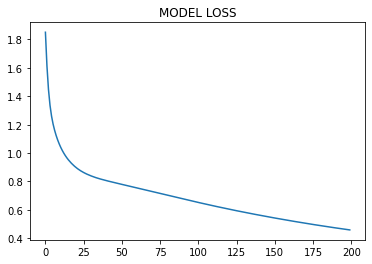

In [13]:
plt.plot(model.loss)
plt.title('MODEL LOSS')

Text(0.5, 1.0, 'MODEL ACCURACY')

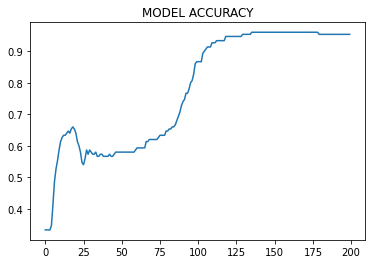

In [14]:
plt.plot(model.accuracy)
plt.title('MODEL ACCURACY')

In [104]:
model1 = Network()
model1.add(DenseLayer(6))
model1.add(DenseLayer(10))
model1.add(DenseLayer(8))
model1.add(DenseLayer(5))

model1.train(X_train=X, y_train=y, epochs=200)

EPOCH: 0, ACCURACY: 0.0, LOSS: 3.4108930670071502
EPOCH: 20, ACCURACY: 0.36666666666666664, LOSS: 1.1936043594679888
EPOCH: 40, ACCURACY: 0.3466666666666667, LOSS: 1.118932842322857
EPOCH: 60, ACCURACY: 0.66, LOSS: 0.9708749881783422
EPOCH: 80, ACCURACY: 0.6666666666666666, LOSS: 0.8042474571794903
EPOCH: 100, ACCURACY: 0.8266666666666667, LOSS: 0.6681771644675543
EPOCH: 120, ACCURACY: 0.9133333333333333, LOSS: 0.5668208375141273
EPOCH: 140, ACCURACY: 0.9466666666666667, LOSS: 0.49042298732862266
EPOCH: 160, ACCURACY: 0.96, LOSS: 0.4332030745379141
EPOCH: 180, ACCURACY: 0.96, LOSS: 0.3895659120584873


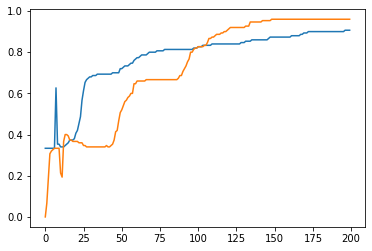

In [105]:
plt.plot(model.accuracy)
plt.plot(model1.accuracy)